In [1]:
import torch
import random
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# loading dataset
words = open(r"data\names.txt").read().splitlines()
print(f"Number of words: {len(words)}")
print(f"first 5 words: {words[:5]}")

Number of words: 55272
first 5 words: ['parish', 'manhi', 'akshaykeerti', 'suran', 'tomali']


In [3]:
# creating a look up table (dictionary to map int to characters and vice versa)
chars = sorted(list(set(''.join(words))))
ch_to_id = {ch:i+1 for i, ch in enumerate(chars)}
ch_to_id['.'] = 0 # special char to mark ending and starting of a word
vocab_size = len(ch_to_id)
id_to_ch = {i:ch for ch, i in ch_to_id.items()}
print(f"Charecters to id: {ch_to_id}")
print(f"Id to charecters: {id_to_ch}")
print(f"Vocab size: {vocab_size}")

Charecters to id: {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
Id to charecters: {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
Vocab size: 27


In [4]:
# building our datasets: training split(80%), dev/validation split(10%) and test split(10%)

block_size = 8 # context length: how many charecters to consider to predict the next charecter
def buid_dataset(words, str):
    X, Y = [], [] # X: context, Y: target
    for word in words:
        context = [0] * block_size
        for ch in word + ".": # adding a special char to mark the end of a word
            current_idx = ch_to_id[ch]
            X.append(context)
            Y.append(current_idx)
            context = context[1:] + [current_idx] # sliding the context window
            
    # converting the dataset to tensors        
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(f"\nX_{str} shape: {X.shape}")
    print(f"Y_{str} shape: {Y.shape}")
    return X, Y

random.shuffle(words)
lim1 = int(len(words) * 0.8)
lim2 = int(len(words) * 0.9)

X_train, Y_train = buid_dataset(words[:lim1], "train")
X_dev, Y_dev = buid_dataset(words[lim1:lim2], "dev")
X_test, Y_test = buid_dataset(words[lim2:], "test")


X_train shape: torch.Size([401629, 8])
Y_train shape: torch.Size([401629])

X_dev shape: torch.Size([50198, 8])
Y_dev shape: torch.Size([50198])

X_test shape: torch.Size([50140, 8])
Y_test shape: torch.Size([50140])


In [5]:
# insights into dataset
for x,y in zip(X_train[:20], Y_train[:20]):
  print(''.join(id_to_ch[ix.item()] for ix in x), '-->', id_to_ch[y.item()])

........ --> p
.......p --> r
......pr --> i
.....pri --> y
....priy --> a
...priya --> d
..priyad --> h
.priyadh --> a
priyadha --> r
riyadhar --> s
iyadhars --> i
yadharsi --> n
adharsin --> i
dharsini --> .
........ --> d
.......d --> a
......da --> y
.....day --> a
....daya --> m
...dayam --> a


In [88]:
# Pytorchyfying elmo 2.0

# Linear class
class Linear:
    
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # kaming init
        self.bias = torch.zeros(fan_out) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
# BatchNorm class
class BatchNorm1d:
    
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # params
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self, x):
        # forward pass
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0, 1)
            xmean = x.mean(dim, keepdim=True) # batch mean
            xvar = x.var(dim, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize
        self.out = self.gamma * xhat + self.beta
        # update buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
# Activation class
class Tanh:
    
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []
    
# Embedding class
class Embedding:
    
    def __init__(self, num_embeddings, embeddings_dim):
        self.weight = torch.randn((num_embeddings, embeddings_dim))
        
    def __call__(self, idx):
        self.out = self.weight[idx]
        return self.out
        
    def parameters(self):
        return [self.weight]
    
# class to perfom embedding operations
class FlattenConsecutive:
    
    def __init__(self, n):
        self.n = n
    
    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T//self.n, C*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out
    
    def parameters(self):
        return []
    
# class to bind all layers together
class Sequential:
    
    def __init__(self, layers):
        self.layers = layers
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [89]:
# initialization
num_embd = 24 # embedding vector dimensions
num_hidden = 128 # num neurons hidden layer

model = Sequential([
  Embedding(vocab_size, num_embd),
  FlattenConsecutive(2), Linear(num_embd * 2, num_hidden, bias=False), BatchNorm1d(num_hidden), Tanh(),
  FlattenConsecutive(2), Linear(num_hidden*2, num_hidden, bias=False), BatchNorm1d(num_hidden), Tanh(),
  FlattenConsecutive(2), Linear(num_hidden*2, num_hidden, bias=False), BatchNorm1d(num_hidden), Tanh(),
  Linear(num_hidden, vocab_size),
])

with torch.no_grad():
  # last layer make less confident
  model.layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

76579


In [90]:
# optimization
max_steps = 200000
batch_size = 32
lossi = []

for i in tqdm(range(max_steps), desc="", bar_format="\033[32m{l_bar}{bar}\033[0m"):
  # minibatches
  idx = torch.randint(0, X_train.shape[0], (batch_size,))
  mini_X, mini_Y = X_train[idx], Y_train[idx] # batch X,Y
  
  # forward pass
  logits = model(mini_X)
  loss = F.cross_entropy(logits, mini_Y) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'Step: \033[93m{i:7d}/{max_steps:7d}\033[0m: Loss: \033[93m{loss.item():.4f}\033[0m')
  lossi.append(loss.log10().item())
  
print(f"Final loss: {loss}")

  0%|          

Step:       0/ 200000: Loss: 3.2931


  5%|▌         

Step:   10000/ 200000: Loss: 1.5852


 10%|█         

Step:   20000/ 200000: Loss: 1.6541


 15%|█▌        

Step:   30000/ 200000: Loss: 1.8202


 20%|██        

Step:   40000/ 200000: Loss: 1.6653


 25%|██▌       

Step:   50000/ 200000: Loss: 1.9229


 30%|███       

Step:   60000/ 200000: Loss: 1.7600


 35%|███▌      

Step:   70000/ 200000: Loss: 1.8752


 40%|████      

Step:   80000/ 200000: Loss: 2.3196


 45%|████▌     

Step:   90000/ 200000: Loss: 2.0713


 50%|█████     

Step:  100000/ 200000: Loss: 1.9093


 55%|█████▌    

Step:  110000/ 200000: Loss: 1.8865


 60%|██████    

Step:  120000/ 200000: Loss: 1.9386


 65%|██████▌   

Step:  130000/ 200000: Loss: 1.6440


 70%|███████   

Step:  140000/ 200000: Loss: 2.1550


 75%|███████▌  

Step:  150000/ 200000: Loss: 1.4115


 80%|████████  

Step:  160000/ 200000: Loss: 1.6218


 85%|████████▌ 

Step:  170000/ 200000: Loss: 1.4906


 90%|█████████ 

Step:  180000/ 200000: Loss: 2.0452


 95%|█████████▌

Step:  190000/ 200000: Loss: 1.6821


100%|██████████

Final loss: 1.7804011106491089


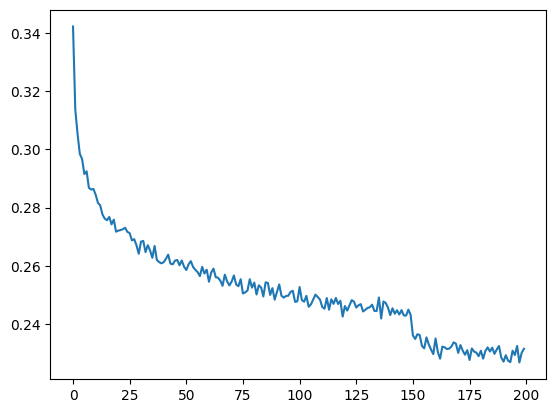

In [91]:
# plotting loss
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [92]:
# putting layers in eval mode
for layer in model.layers:
    layer.training = False

In [93]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (X_train, Y_train),
    'val': (X_dev, Y_dev),
    'test': (X_test, Y_test),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.6917644739151
val 1.7702360153198242


In [94]:
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(id_to_ch[i] for i in out)) # decode and print the generated word

amalarasuri.
rohapriya.
iznk.
dwalasan.
aswethigasri.
pranavan.
gnanoosri.
tanshya.
mathyavari.
padavarsini.
jegadambini.
eezhina.
niliyavan.
deshanthanan.
moushil.
safvinthalasen.
brithira.
parethini.
achan.
gaurishikant.
